# 2023-07-10__AdEx_STA_Nto1

In [1]:
%run lib/neuron.py

importing numpy, brian … ✔


In [2]:
μₓ = 4 * Hz
σ = sqrt(0.6)
μ = log(μₓ / Hz) - σ**2 / 2

1.0862943611198905

In [3]:
def Nto1(N = 6500):
    
    Ne = N * 4//5
    
    n = COBA_AdEx_neuron()
    
    rates = lognormal(μ, σ, N) * Hz;
    P = PoissonGroup(N, rates)
    
    Se = Synapses(P, n, on_pre="ge += we")
    Si = Synapses(P, n, on_pre="gi += wi")
    Se.connect("i < Ne")
    Si.connect("i >= Ne")
    
    M = StateMonitor(n, ["V"], record=[0])
    S = SpikeMonitor(n)
    SP = SpikeMonitor(P)
    
    objs = [n, P, Se, Si, M, S, SP]
    return *objs, Network(objs)

In [4]:
n, P, Se, Si, M, S, SP, net = Nto1()
net.store()

In [5]:
net.restore()
we = 14 * pS
wi = 4 * we
T = 0.1 * second
net.run(T, report='text')

Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


In [6]:
%run lib/diskcache.py

In [7]:
T = 10 * second

@cache("2023-07-10__AdEx_STA_Nto1")
def sim(we, seed):
    net.restore()
    set_seed(seed)
    net.run(T)
    v = ceil_spikes(M, S)
    return dict(
        we   = we,
        seed = seed,
        median_Vm   = median(v),
        output_rate = S.num_spikes / T,
    )

In [8]:
minute = 60*second;

In [9]:
ws = [0, 2.5, 5, 7.5, 10, 11, 12, 12.5, 13, 14, 15, 16, 17.5, 20, 22.5, 25, 27.5, 30] * pS
# ws = [0, 5, 10, 15, 30] * pS
seeds = range(5)
# seeds = [2]

len(ws) * len(seeds) * 14*second / minute

21.0

In [10]:
# from tqdm import tqdm

In [11]:
data = []
for we in (ws):
    wi = 4 * we
    for seed in (seeds):
        d = sim(we, seed)
        data.append(d)

In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame(data)
df.head()

,we,seed,median_Vm,output_rate
0,0. S,0,-64.99999991 mV,0. Hz
1,0. S,1,-64.99999991 mV,0. Hz
2,0. S,2,-64.99999991 mV,0. Hz
3,0. S,3,-64.99999991 mV,0. Hz
4,0. S,4,-64.99999991 mV,0. Hz


In [14]:
from collections import Counter

def units_to_header(df):
    df = df.copy()
    for col in df:
        x = df[col].values[-1]
        if type(x) == Quantity:
            c = Counter(el.get_best_unit() for el in df[col])
            unit = c.most_common()[0][0]
            df[col] = [val / unit for val in df[col]]
            df[col].unit = unit
            df.rename(columns={col: f"{col}_{unit}"}, inplace=True)
        else:
            df[col].unit = None
    return df

In [15]:
df = units_to_header(df)

,we_pS,seed,median_Vm_mV,output_rate_Hz
0,0.0,0,-65.000000,0.0
1,0.0,1,-65.000000,0.0
2,0.0,2,-65.000000,0.0
3,0.0,3,-65.000000,0.0
4,0.0,4,-65.000000,0.0
...,...,...,...,...
85,30.0,0,-53.244961,13.1
86,30.0,1,-53.229719,13.0
87,30.0,2,-53.184055,13.0
88,30.0,3,-53.166093,13.2


In [17]:
!mkdir data
df.to_csv("data/2023-07-10__AdEx_STA_Nto1_sim.csv")

In [18]:
# groupby no work w/ brian units
df.groupby("we_pS").mean()

,seed,median_Vm_mV,output_rate_Hz
we_pS,,,
0.0,2.0,-65.000000,0.00
2.5,2.0,-60.664055,0.00
5.0,2.0,-57.590947,0.00
7.5,2.0,-55.287565,0.00
10.0,2.0,-53.424034,0.04
11.0,2.0,-53.123190,0.98
12.0,2.0,-53.468735,2.22
12.5,2.0,-53.631235,2.74
13.0,2.0,-53.834430,3.18


In [19]:
%run lib/plot.py

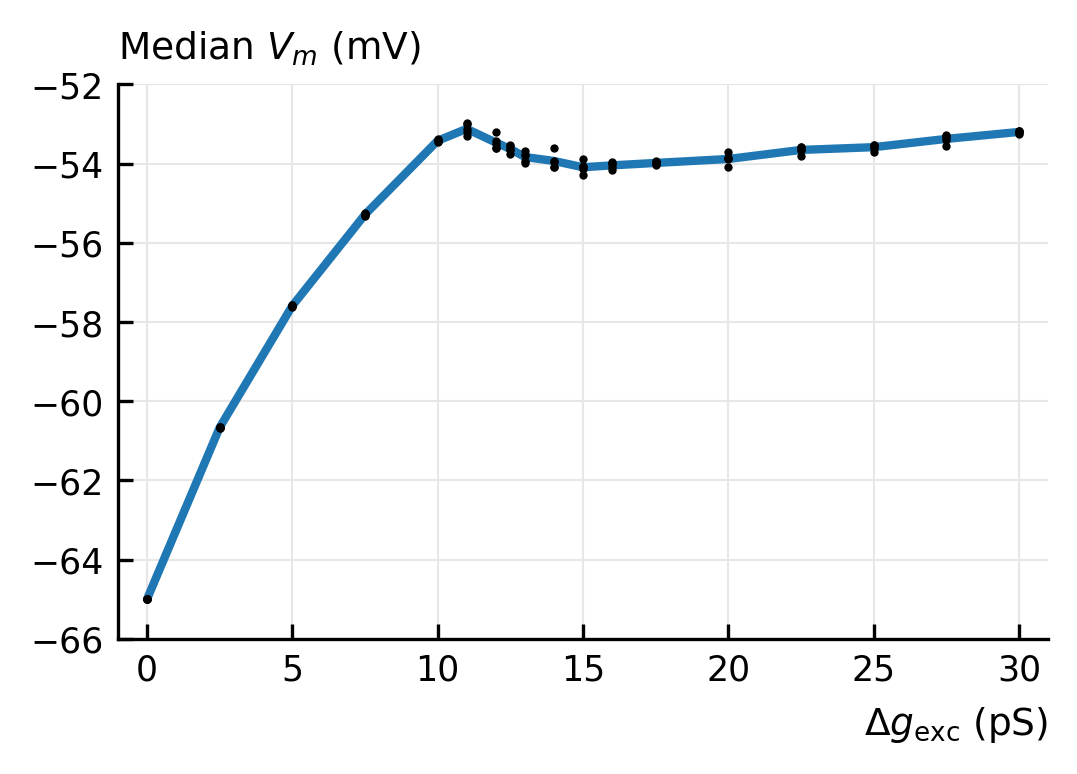

In [20]:
def plot_dots_and_means(x, y, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    xu = unique(x)
    ym = [mean(y[x == xi]) for xi in xu]
    ax.plot(xu, ym, "-", lw=2)
    ax.plot(x, y, "k.", ms=4, mfc='k', mec='none')
    
fig, ax = plt.subplots()
plot_dots_and_means(df.we_pS, df.median_Vm_mV, ax)
hylabel(ax, "Median $V_m$ (mV)")
xl = "$Δg_\\mathrm{exc}$ (pS)"
xlim(-1, 31)
xlabel(xl);

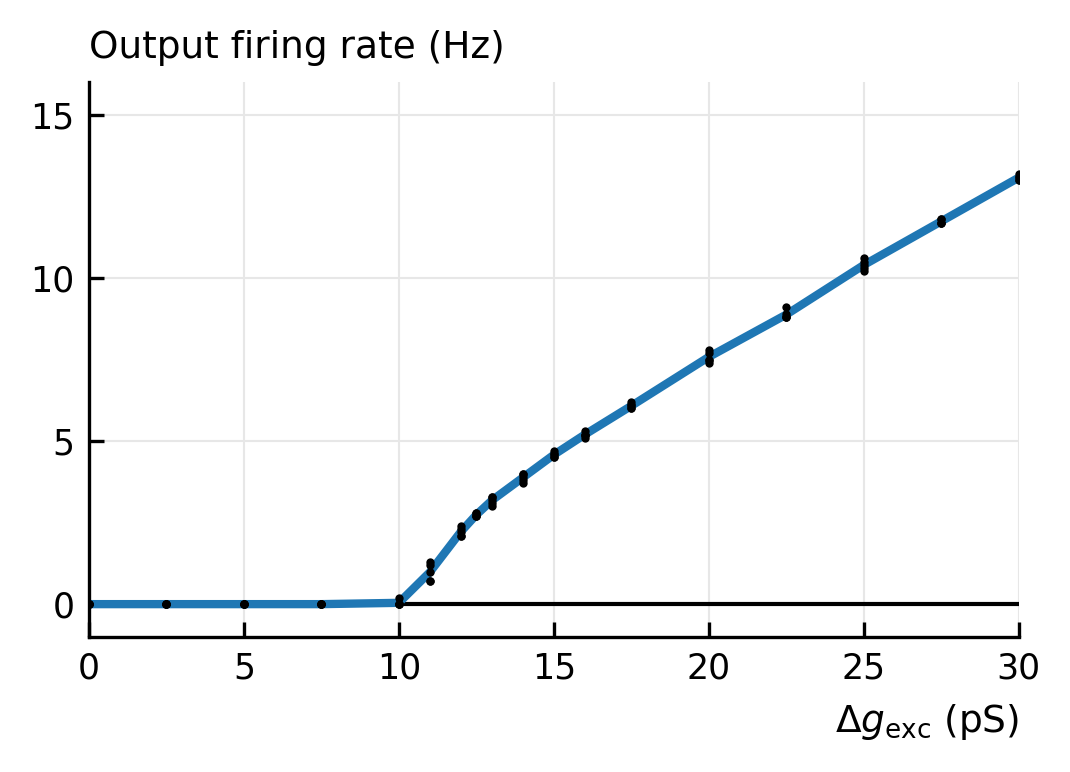

In [22]:
fig, ax = plt.subplots()
axhline(0, 0, 1, c="black", lw=1)
plot_dots_and_means(df.we_pS, df.output_rate_Hz, ax)
hylabel(ax, "Output firing rate (Hz)")
ylim(-1, 16)
xlabel(xl);

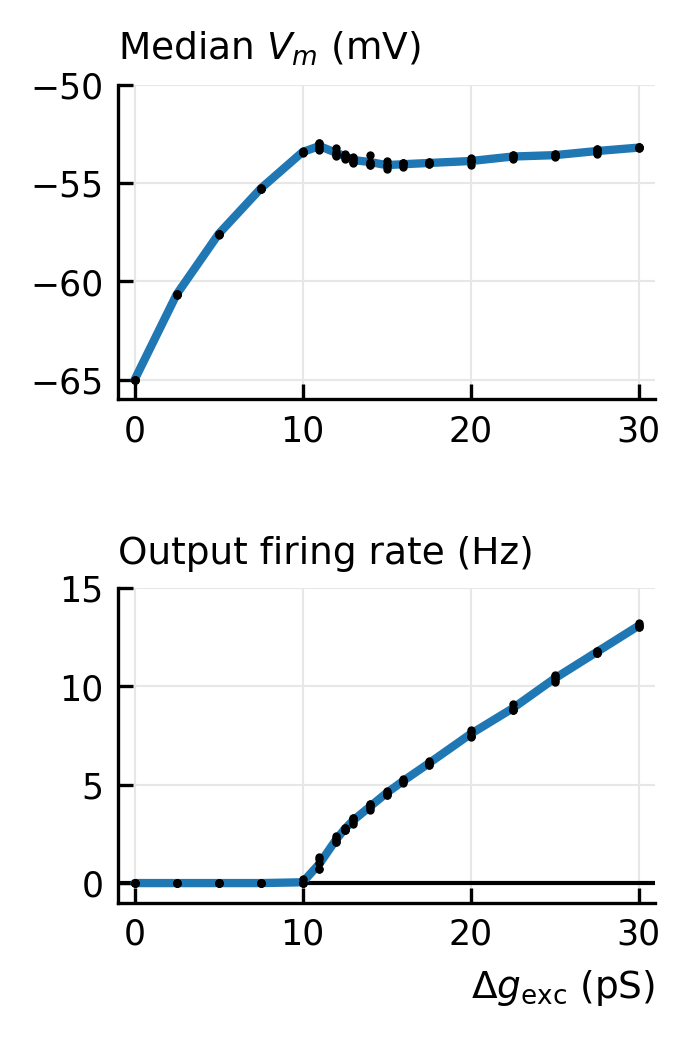

In [26]:
fig, axs = plt.subplots(figsize=(2.4, 3.4), nrows=2)
axs[1].axhline(0, 0, 1, c="black", lw=1)
plot_dots_and_means(df.we_pS, df.median_Vm_mV, axs[0])
plot_dots_and_means(df.we_pS, df.output_rate_Hz, axs[1])
axs[1].set_ylim(-1, 15)
axs[1].set_xlim(-1, 31)
axs[0].set_xlim(-1, 31)
axs[0].set_ylim(-66, -50)
hylabel(axs[0], "Median $V_m$ (mV)")
hylabel(axs[1], "Output firing rate (Hz)")
plt.tight_layout(h_pad=2)
axs[1].set_xlabel(xl)
savefig_("input_drive_we")

In [14]:
from julia import Base

In [15]:
Base.sin(8)

0.9893582466233818